In [2]:
import numpy as np
from numpy import sin, cos
from numpy.linalg import eigvals, eig

# from .utils import kroneckerdelta, product, crct, submatrix, adjugate

class MatSolver:
    def __init__(self, baseline, energy, V, delmsq21, delmsq31, deltacp, theta12, theta13, theta23):
        self.baseline = baseline
        self.energy = energy
        self.deltacp = deltacp
        self.theta12 = theta12
        self.theta13 = theta13
        self.theta23 = theta23
        self.V = V

        self.delmsq21 = delmsq21
        self.delmsq31 = delmsq31

        alpha = delmsq21 / delmsq31
        a = (2 * energy * V)/delmsq31

        self.O12 = O12 = np.matrix([[cos(theta12), sin(theta12), 0], [-sin(theta12), cos(theta12), 0], [0, 0, 1]])
        self.O13 = O13 = np.matrix([[cos(theta13), 0, sin(theta13)], [0, 1, 0], [-sin(theta13), 0, cos(theta13)]])
        self.O23 = O23 = np.matrix([[1, 0, 0], [0, cos(theta23), sin(theta23)], [0, -sin(theta23), cos(theta23)]])
        self.Udelta = Udelta = np.matrix(np.diag([1, 1, np.exp(1j * deltacp)]))

        self.M = M = O13 @ O12 @ np.diag([0, alpha, 1]) @ O12.T @ O13.T + np.diag([a, 0, 0])
        self.H = H = O23 @ Udelta @ M @ Udelta.H @ O23.T

    def Hevals(self):
        H = self.H
        return eigvals(H)
    
    def probabilities(self):
        labelmatrix = np.matrix([["Pee", "Pemu", "Petau"], ["Pmue", "Pmumu", "Pmutau"], ["Ptaue", "Ptaumu", "Ptautau"]])

        probmatrix = np.zeros((3, 3))

        for i in range(1, 4):
            for j in range(1, 4):
                label = labelmatrix[i - 1, j - 1]

                if i == j:
                    prob = self.disappearance(i)
                else:
                    prob = self.appearance(i, j)

                # print(f"{label}: {prob}")
                
                probmatrix[i - 1, j - 1] = prob

        return probmatrix

class Eigen(MatSolver):
    def __init__(self, *args):
        super().__init__(*args)

    def Hevecs(self):
        H = self.H
        return eig(H)[1]
    
    def evolution_matrix(self):
        lda1, lda2, lda3 = self.Hevals()
        evecs = self.Hevecs()

        L = self.baseline
        En = self.energy
        delmsq31 = self.delmsq31
        delta = (1.267 * delmsq31 * L)/En

        eigmat = np.matrix(evecs)

        S = eigmat @ np.diag([np.exp(-1j * lda1 * 2 * delta), np.exp(-1j * lda2 * 2 * delta), np.exp(-1j * lda3 * 2 * delta)]) @ eigmat.H
        return S
    
    def probability(self, i, j):
        i, j = crct(i, j)

        S = self.evolution_matrix()

        return np.abs(S[j, i])**2
    
    def disappearance(self, i):
        return self.probability(i, i)

    def appearance(self, i, j):
        return self.probability(i, j)
    
class CayleyHamilton(MatSolver):
    def __init__(self, *args):
        super().__init__(*args)
    
    def evolution_matrix(self):
        H = self.H
        lda1, lda2, lda3 = self.Hevals()

        L = self.baseline
        En = self.energy
        delmsq31 = self.delmsq31
        delta = (1.267 * delmsq31 * L)/En

        S = (np.exp(-1j * lda1 * 2 * delta)/((lda1 - lda2) * (lda1 - lda3))) * (lda2 * lda3 * np.identity(3) - (lda2 + lda3) * H + H @ H) +\
        (np.exp(-1j * lda2 * 2 * delta)/((lda2 - lda1) * (lda2 - lda3))) * (lda1 * lda3 * np.identity(3) - (lda1 + lda3) * H + H @ H) +\
        (np.exp(-1j * lda3 * 2 * delta)/((lda3 - lda1) * (lda3 - lda2))) * (lda1 * lda2 * np.identity(3) - (lda1 + lda2) * H + H @ H)

        return S
    
    def probability(self, i, j):
        i, j = crct(i, j)

        S = self.evolution_matrix()

        return np.abs(S[j, i])**2
    
    def disappearance(self, i):
        return self.probability(i, i)

    def appearance(self, i, j):
        return self.probability(i, j)

class Identities(MatSolver):
    def __init__(self, *args):
        super().__init__(*args)

    def submatrix_evals(self):
        H = self.H

        He = submatrix(H, 1)
        Hmu = submatrix(H, 2)
        Htau = submatrix(H, 3)

        Xie, Chie = eigvals(He)
        Ximu, Chimu = eigvals(Hmu)
        Xitau, Chitau = eigvals(Htau)

        return [[Xie, Chie], [Ximu, Chimu], [Xitau, Chitau]]
    
    def quartic_product(self, i, alpha, beta):
        i, alpha, beta = crct(i, alpha, beta)

        H = self.H
        lda = self.Hevals()

        adj = adjugate(lda[i] * np.identity(3) - H)[alpha, beta]
        denom = product([lda[i] - lda[k] if k != i else 1 for k in range(3)])

        qprod = adj / denom

        return qprod

    def PMNSmattermodsq(self, alpha, i):
        alpha, i = crct(alpha, i)

        lda = self.Hevals()
        subeigs = self.submatrix_evals()

        sublda = subeigs[alpha]

        num = product([lda[i] - sublda[j] for j in range(len(sublda))])
        denom = product([lda[i] - lda[k] if k != i else 1 for k in range(3)])

        modsq = num / denom

        return modsq
    
    def mat_deltamsq(self, k, j):
        k, j = crct(k, j)
        lda = self.Hevals()
        delmsq31 = self.delmsq31
        
        return delmsq31 * (lda[k] - lda[j])
    
    def mat_phase(self, k, j, n=1):
        k, j = crct(k, j)

        lda = self.Hevals()

        L = self.baseline
        En = self.energy
        delmsq31 = self.delmsq31
        delta = (1.267 * delmsq31 * L)/En

        return n * (lda[k] - lda[j]) * delta
    
    def disappearance(self, i):
        sum_terms = []
        for j in range(1, 4):
            for k in range(j + 1, 4):
                term = self.PMNSmattermodsq(i, k) * self.PMNSmattermodsq(i, j) * sin(self.mat_phase(k, j))**2
                sum_terms.append(term)

        return (1 - 4 * sum(sum_terms)).real
    
    def appearance(self, a, b):
        firstsum = []
        for j in range(1, 4):
            for k in range(j + 1, 4):
                term = (self.quartic_product(k, b, a) * self.quartic_product(j, a, b)).real * sin(self.mat_phase(k, j))**2
                firstsum.append(term)
        firstsum = sum(firstsum)

        secondsum = []
        for j in range(1, 4):
            for k in range(j + 1, 4):
                term = (self.quartic_product(k, b, a) * self.quartic_product(j, a, b)).imag * sin(self.mat_phase(k, j, 2))
                secondsum.append(term)
        secondsum = sum(secondsum)

        return (kroneckerdelta(a, b) - 4 * firstsum + 2 * secondsum).real       
    
    def mat_mixing_angles(self):
        s13matsq = self.PMNSmattermodsq(1, 3).real
        c13matsq = 1 - s13matsq

        s12matsq = self.PMNSmattermodsq(1, 2).real / c13matsq
        s23matsq = self.PMNSmattermodsq(2, 3).real / c13matsq

        s12mat = np.sqrt(s12matsq)
        s13mat = np.sqrt(s13matsq)
        s23mat = np.sqrt(s23matsq)

        theta12mat = np.arcsin(s12mat)
        theta13mat = np.arcsin(s13mat)
        theta23mat = np.arcsin(s23mat)

        return theta12mat, theta13mat, theta23mat
    
    def toshev_identity(self):
        _, _, theta23mat = self.mat_mixing_angles()

        deltacp = self.deltacp
        theta23 = self.theta23

        matsindeltacp = (sin(2 * theta23)/sin(2 * theta23mat)) * sin(deltacp)

        matdeltacp = np.arcsin(matsindeltacp)

        return matdeltacp

    def mat_angles_phase(self):
        theta12mat, theta13mat, theta23mat = self.mat_mixing_angles()
        matdeltacp = self.toshev_identity()

        return matdeltacp, theta12mat, theta13mat, theta23mat
    
    def PMNSmat(self):
        deltacp, theta12, theta13, theta23 = self.mat_angles_phase()

        O12 = np.matrix([[cos(theta12), sin(theta12), 0], [-sin(theta12), cos(theta12), 0], [0, 0, 1]])
        O13 = np.matrix([[cos(theta13), 0, sin(theta13)], [0, 1, 0], [-sin(theta13), 0, cos(theta13)]])
        O23 = np.matrix([[1, 0, 0], [0, cos(theta23), sin(theta23)], [0, -sin(theta23), cos(theta23)]])
        Udelta = np.matrix(np.diag([1, 1, np.exp(1j * deltacp)]))

        PMNSmat = O23 @ Udelta @ O13 @ Udelta.H @ O12

        return PMNSmat


In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [31]:
M = np.array([[-0.00163698+0.j, -0.11756212+0.j, -0.09929616+0.j],
 [-0.11756212+0.j, -0.46693582+0.j, -0.47653151+0.j],
 [-0.09929616+0.j, -0.47653151+0.j, -0.4710272 +0.j]])

print(np.linalg.det(M))

print(np.prod(np.linalg.eigvals(M)))

U, s, Vh = np.linalg.svd(M)
print(np.prod(s))

sign, log_det = np.linalg.slogdet(M)

# Compute the determinant using the sign and logarithm
print(sign * np.exp(log_det))

(-1.1541261388990514e-11+0j)
(-1.1541261971638508e-11+0j)
1.1541260796039843e-11
(-1.1541261388990514e-11+0j)


In [19]:
# from pytrino import oscprobs

# deltacp = np.pi/6
# theta13 = np.pi/20
# theta12 = np.pi/6
# theta23 = np.pi/4

# delmsq31 = 2.6e-3
# delmsq21 = 6.9e-5

# baseline = 1
# energy = 0.001

print(Identities(10, 0.001, 0.26, 7.55e-05, 0.0025, 0, 0.5235987755982988, 0.15707963267948966, 0.7853981633974483).appearance(1, 2))


0.20800000000000002
7.32298930681463e-05


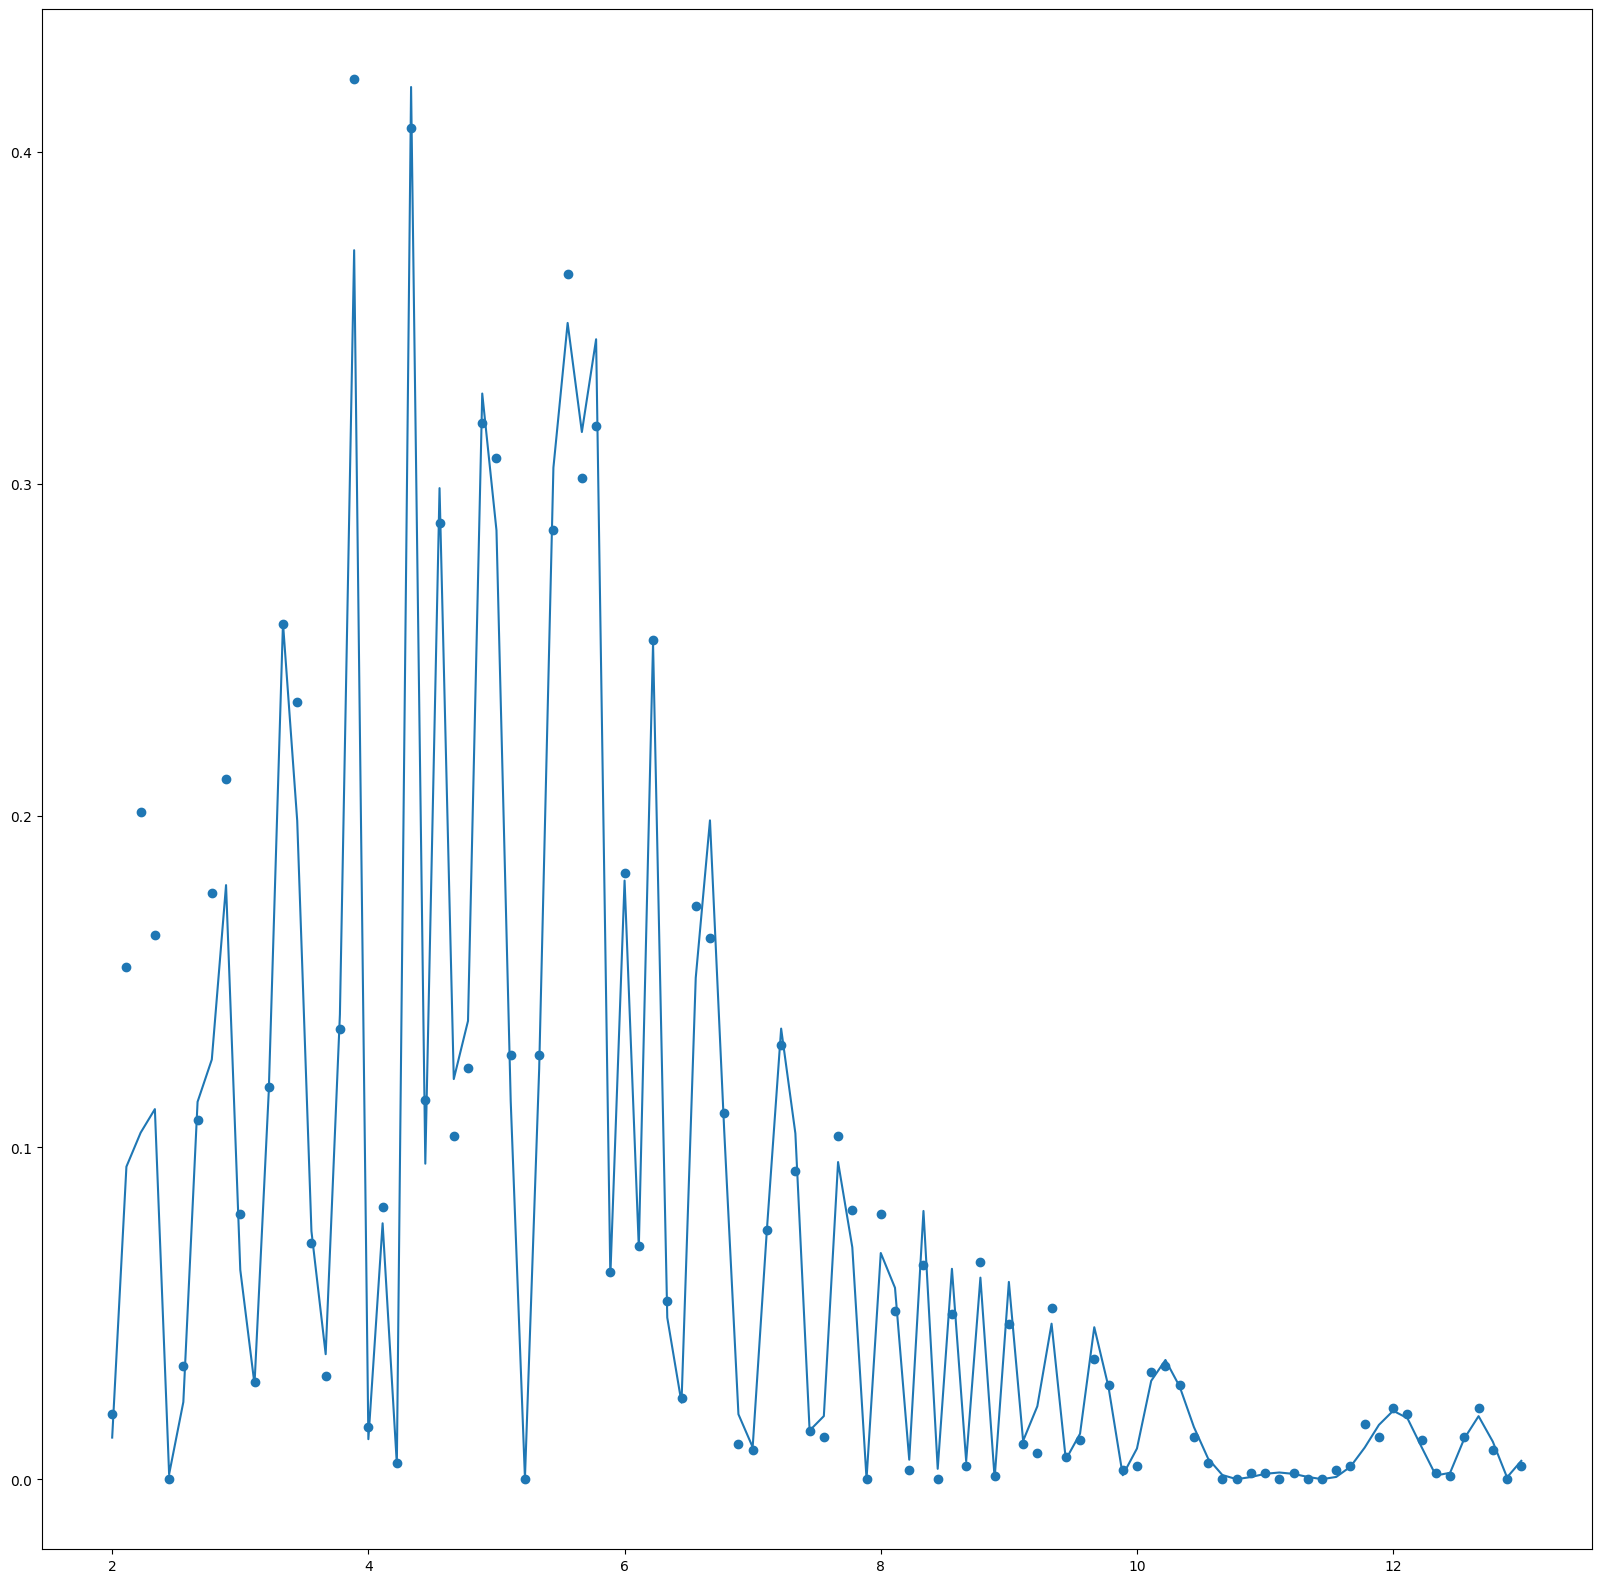

In [7]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.extensions import CU3Gate, UnitaryGate
import numpy as np
import matplotlib.pyplot as plt

# from pytrino import oscprobs

%matplotlib inline

# Define the parameters for neutrino oscillations
deltacp = np.pi/6
theta13 = np.pi/20
theta12 = np.pi/6
theta23 = np.pi/4

delmsq31 = 2.5e-3
delmsq21 = 7.55e-5

L = 1300 # 100 * 1e+3  # Distance traveled by the neutrino (in km)
# E = 0.001 # 0.001 * 1e+9  # Energy of the neutrino (in GeV)

V = 0.25

def R_12(qc, theta, delta):
    qc.x(0)
    qc.append(CU3Gate(-2 * theta, delta, -delta), [0, 1]) # [control_qubit, target_qubit]
    qc.x(0)

def R_13(qc, theta, delta):
    qc.swap(0, 1)

    qc.x(0)
    qc.append(CU3Gate(-2 * theta, delta, -delta), [0, 1]) # [control_qubit, target_qubit]
    qc.x(0)

    qc.swap(0, 1)

def R_23(qc, theta, delta):
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)

    qc.swap(0, 1)

    qc.x(0)
    qc.append(CU3Gate(-2 * theta, delta, -delta), [0, 1]) # [control_qubit, target_qubit]
    qc.x(0)

    qc.swap(0, 1)

    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)

def Udelta(qc, delta):
    qc.swap(0, 1)

    qc.x(0)
    qc.append(CU3Gate(0, delta/2, delta/2), [0, 1]) # [control_qubit, target_qubit]
    qc.x(0)

    qc.swap(0, 1)

def osc_prob(E):
    global theta12, theta13, theta23, deltacp, delmsq31, delmsq21, L, V
    
    obj = Identities(L, E, V, delmsq21, delmsq31, deltacp, theta12, theta13, theta23)
    
    deltacpmat, theta12mat, theta13mat, theta23mat = obj.mat_angles_phase()
    
    # print(deltacp, theta12, theta13, theta23)
    # print(deltacpmat, theta12mat, theta13mat, theta23mat)
    # print()
    
    delmsq31mat = obj.mat_deltamsq(3, 1).real
    delmsq21mat = obj.mat_deltamsq(2, 1).real
    
#     print(delmsq31, delmsq31mat)
#     print(delmsq21, delmsq21mat)


    def PMNS(qc, dagger = False):
        # global theta12, theta13, theta23, deltacp
    
        if not dagger:
            R_12(qc, theta12mat, 0)
            Udelta(qc, -deltacpmat)
            R_13(qc, theta13mat, 0)
            Udelta(qc, deltacpmat)
            R_23(qc, theta23mat, 0)
        else:
            R_23(qc, -theta23mat, 0)
            Udelta(qc, -deltacpmat)
            R_13(qc, -theta13mat, 0)
            Udelta(qc, deltacpmat)
            R_12(qc, -theta12mat, 0)

    def S(qc):
        # global delmsq31, delmsq21, L
        
        phase31 = -2 * ((1.267 * delmsq31mat * L)/E)
        phase21 = -2 * ((1.267 * delmsq21mat * L)/E)
        
        # matrix = np.matrix(np.diag([1, np.exp(1j * phase21), np.exp(1j * phase31), 1]))
        
        # custom_gate = UnitaryGate(matrix)
        
        # qc.append(custom_gate, [0, 1])
        
        qc.p(phase31, 0)
        qc.p(phase21, 1)
        
    # Create a quantum circuit with 2 qubits
    qc = QuantumCircuit(2, 2)
    
    qc.initialize('01', qc.qubits)
    
    PMNS(qc, dagger=True)
    S(qc)
    PMNS(qc)

#     display(qc.draw('mpl'))

    qc.measure(range(2), range(2))

    # # Define the simulator backend
    backend = Aer.get_backend('qasm_simulator')

    shots = 1024

    # # Execute the circuit and get the results
    job = execute(qc, backend, shots=shots)
    counts = job.result().get_counts(qc)
    
    # print(counts)
    
    try:
        prob = counts['00']/shots
    except:
        prob = 0

    return prob

def theoretical_osc_prob(E):
    global theta12, theta13, theta23, deltacp, delmsq31, delmsq21, L, V
    
    prob = Identities(L, E, V, delmsq21, delmsq31, deltacp, theta12, theta13, theta23)
    Pee = prob.appearance(1, 2)

    return Pee

tprobs = []
eprobs = []

x = np.linspace(2, 13, 100)

for en in x:
    en = en * 1e-3
    eprobs.append(osc_prob(en))
    tprobs.append(theoretical_osc_prob(en))
    
plt.figure(figsize=(20, 20))

plt.plot(x, tprobs)
plt.scatter(x, eprobs)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute

# Define the initial state of the neutrino
initial_state = [1, 0]  # Pure |ν_e⟩ state

# Define the oscillation parameters
theta = 0.587  # Mixing angle (in radians)
delta = 1.571  # Phase difference (in radians)

# Define the time evolution factor
t = 1  # Time in arbitrary units

# Theoretical calculation of oscillation probabilities
P_ee = np.cos(theta)**2 + np.sin(theta)**2 * np.cos(2 * delta) * np.sin(theta)**2 * np.sin(t)**2
P_emu = np.sin(theta)**2 - np.sin(theta)**2 * np.cos(2 * delta) * np.sin(theta)**2 * np.sin(t)**2

# Create a quantum circuit with 1 qubit
qc = QuantumCircuit(1)

# Initialize the qubit with the initial state
qc.initialize(initial_state, 0)

# Perform the neutrino oscillation
qc.ry(2 * theta, 0)  # Apply the rotation around the y-axis
qc.rz(delta, 0)     # Apply the rotation around the z-axis

# Measure the qubit
qc.measure_all()

# Simulate the circuit
simulator = Aer.get_backend('aer_simulator')
job = execute(qc, simulator, shots=1024)
result = job.result()
counts = result.get_counts(qc)

# Calculate the probabilities from the measurement results
P_ee_exp = counts.get('0', 0) / 1024
P_emu_exp = counts.get('1', 0) / 1024

# Print the theoretical and experimental probabilities
print("Theoretical probabilities:")
print("P(ν_e -> ν_e):", P_ee)
print("P(ν_e -> ν_μ):", P_emu)
print("\nExperimental probabilities:")
print("P(ν_e -> ν_e):", P_ee_exp)
print("P(ν_e -> ν_μ):", P_emu_exp)

# Plot the probabilities
labels = ['ν_e', 'ν_μ']
theoretical_probs = [P_ee, P_emu]
experimental_probs = [P_ee_exp, P_emu_exp]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, theoretical_probs, width, label='Theoretical')
rects2 = ax.bar(x + width/2, experimental_probs, width, label='Experimental')

ax.set_ylabel('Probability')
ax.set_title('Neutrino Oscillation Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()

# Attach a label to each bar displaying the probability
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


In [3]:
!pip uninstall pytrino --yes

In [7]:
!pip install pytrino==0.0.6


[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
